## CSCS530 Winter 2019
#### Complex Systems 530 - Computer Modeling of Complex Systems (Winter 2019)

  * Course ID: CMPLXSYS 530
  * Course Title: Computer Modeling of Complex Systems
  * Term: Winter 2019


### HIV Model Outline

### Goal
  We will examine policy interventation strategies to address and control the spread of HIV in a sexual network.

### Justification
  Given the heterogeneity of behavior and network effects of sexually-transmitted diseases, this problem requires ABM and network methodology.  Differential equation compartment models will not allow for incomplete or scale-free graph structures or time-varying agent behavior, and so cannot be used.  
  
### Outline

  * Implement condom subsidy mechanics
  * Vary condom subsidy 
  * Observe number of steps to 50% infected
  * Observe the mean and standard deviation of sexual partner degree distribution
 

To formally describe our model, let's break it down into pieces:

### I. Space
  In this model, our space will be a two-dimensional (2D) square grid.  Each grid cell will contain zero or one people.  Edges of the grid will wrap around.

### II. Actors

#### A. People
 In this case, people are the carriers of HIV.  We are modeling them as simply as possible, using only the following properties:
 
 ** Properties **
   * _is_infected_: is the person infected with HIV?
   * _condom_budget_: what is the person's budget for protection?
   * _prob_hookup_: what is the probability that a person will want to hookup given contact?
   
For their step function, agents will perform the following:
 
   * take a unit-distance step in a random direction
   * evaluate neighboring cells for any potential people to hookup with
   * for each pair, check against _prob_hookup_; if both people sample True, then hookup
   * for a hookup, check against _max_budget_ and the global condom cost to see if either partner will purchase

#### B. Institution

  A "public health" institution will manage the level of subsidy for condoms.  For now, the subsidy level will be set at $t_0$ and constant over model run.


### III. Initial Conditions

#### A. People
  
  * People will be randomly distributed throughout the grid by sampling from a uniform discrete distribution with replacement.  In the event that an agent has already been placed at the sampled location, we continue drawing a new random position until it is unoccupied.
  * People will have their ``prob_hookup`` randomly initialized to a value from a uniform continuous distribution.
  * People will have their ``condom_budget`` randomly initialized to a value from a uniform continuous distribution.
  * A single person will be selected at random at $t_0$ to have HIV.

#### B. Insitution
  
  The public health institution will set a level of subsidy for condoms using a random uniform continuous distribution.
  
### IV. Model Parameters

  Based on the description above, we need the following model parameters:
  
  * ``grid_size``: size of the two-dimensional square grid, i.e., dimension length
  * ``num_people``: number of persons to create; must be less than ${grid\_size}^2$
  * ``min_subsidy``, ``max_subsidy``: the lower and upper bounds for the institution's subsidy
  * ``min_condom_budget``, ``max_condom_budget``: the lower and upper bounds for initial conditions of people's ``condom_budget``
  * ``condom_cost``: cost of a condom; fixed to $1.0$
  * ``min_prob_hookup``, ``max_prob_hookup``: the lower and upper bounds for initial conditions of people's ``prob_hookup``
  * ``prob_transmit``, ``prob_transmit_condom``: the probability of transmitting the disease without and with a condom

In [1]:
%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import pandas

# Import widget methods
from ipywidgets import interact

## Define our Person and Model

In [2]:
class Person(object):
    """
    Person class, which encapsulates the entire behavior of a person.
    """
    
    def __init__(self, model, person_id, is_infected=False, condom_budget=1.0, prob_hookup=0.5):
        """
        Constructor for Person class.  By default,
          * not infected
          * will always buy condoms
          * will hookup 50% of the time
          
        Note that we must "link" the Person to their "parent" Model object.
        """
        # Set model link and ID
        self.model = model
        self.person_id = person_id
        
        # Set Person parameters.
        self.is_infected = is_infected
        self.condom_budget = condom_budget
        self.prob_hookup = prob_hookup
        
    def decide_condom(self):
        """
        Decide if we will use a condom.
        """
        if self.condom_budget >= (self.model.condom_cost - self.model.condom_subsidy):
            return True
        else:
            return False
    
    def decide_hookup(self):
        """
        Decide if we want to hookup with a potential partner.
        """
        if numpy.random.random() <= self.prob_hookup:
            return True
        else:
            return False
    
    def get_position(self):
        """
        Return position, calling through model.
        """
        return self.model.get_person_position(self.person_id)
    
    def get_neighbors(self):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_person_neighbors(self.person_id)


In [3]:
class Model(object):
    """
    Model class, which encapsulates the entire behavior of a single "run" in our HIV ABM.
    """
    
    def __init__(self, grid_size, num_people, min_subsidy=0.0, max_subsidy=1.0,
                     min_condom_budget=0.0, max_condom_budget=2.0,
                     condom_cost=1.0, min_prob_hookup=0.0, max_prob_hookup=1.0,
                    prob_transmit=0.9, prob_transmit_condom=0.1):
        """
        Class constructor.
        """
        # Set our model parameters; this is long but simple!
        self.grid_size = grid_size
        self.num_people =  num_people
        self.min_subsidy = min_subsidy
        self.max_subsidy = max_subsidy
        self.min_condom_budget = min_condom_budget
        self.max_condom_budget = max_condom_budget
        self.condom_cost = condom_cost
        self.min_prob_hookup = min_prob_hookup
        self.max_prob_hookup = max_prob_hookup
        self.prob_transmit = prob_transmit
        self.prob_transmit_condom = prob_transmit_condom
        
        # Set our state variables
        self.t = 0
        self.space = numpy.array((0,0))
        self.condom_subsidy = 0.0
        self.people = []
        self.num_interactions = 0
        self.num_interactions_condoms = 0
        self.num_infected = 0
        
        # Setup our history variables.
        self.history_space = []
        self.history_space_infected = []
        self.history_interactions = []
        self.history_num_infected = []
        self.history_num_interactions = []
        self.history_num_interactions_condoms = []
        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_people()
        self.setup_institution()
        
    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a NaN's
        self.space = numpy.full((self.grid_size, self.grid_size), numpy.nan)
    
    def setup_people(self):
        """
        Method to setup our space.
        """
        
        # First, begin by creating all agents without placing them.
        for i in xrange(self.num_people):
            self.people.append(Person(model=self,
                                      person_id=i,
                                      is_infected=False,
                                      condom_budget=numpy.random.uniform(self.min_condom_budget, self.max_condom_budget),
                                      prob_hookup=numpy.random.uniform(self.min_prob_hookup, self.max_prob_hookup)))
        
        # Second, once created, place them into the space.
        for person in self.people:
            # Loop until unique
            is_occupied = True
            while is_occupied:
                # Sample location
                random_x = numpy.random.randint(0, self.grid_size)
                random_y = numpy.random.randint(0, self.grid_size)
                
                # Check if unique
                if numpy.isnan(self.space[random_x, random_y]):
                    is_occupied = False
                else:
                    is_occupied = True
            
            # Now place the person there by setting their ID.
            self.space[random_x, random_y] = person.person_id
            
        # Third, pick one person to be infected initially.
        random_infected = numpy.random.choice(range(self.num_people))
        self.people[random_infected].is_infected = True
        self.num_infected += 1

    def setup_institution(self):
        """
        Method to setup our institution.
        """
        # Randomly sample a subsidy level
        self.condom_subsidy = numpy.random.uniform(self.min_subsidy, self.max_subsidy)
    
    def get_neighborhood(self, x, y, distance=1):
        """
        Get a Moore neighborhood of distance from (x, y).
        """
        neighbor_pos = [ ( x % self.grid_size, y % self.grid_size)
                                for x, y in itertools.product(xrange(x-distance, x+distance+1),
                                xrange(y-distance, y+distance+1))]
        return neighbor_pos
    
    def get_neighbors(self, x, y, distance=1):
        """
        Get any neighboring persons within distance from (x, y).
        """
        neighbor_pos = self.get_neighborhood(x, y, distance)
        neighbor_list = []
        for pos in neighbor_pos:
            # Skip identity
            if pos[0] == x and pos[1] == y:
                continue
                
            # Check if empty
            if not numpy.isnan(self.space[pos[0], pos[1]]):
                neighbor_list.append(int(self.space[pos[0], pos[1]]))
        
        return neighbor_list
    
    def get_person_position(self, person_id):
        """
        Get the position of a person based on their ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        return numpy.reshape(numpy.where(self.space == person_id), (1, 2))[0].tolist()

    def get_person_neighbors(self, person_id, distance=1):
        """
        Get the position of a person based on their ID.
        """
        # Find the value that matches our ID in self.space, then reshape to a 2-element list.
        x, y = self.get_person_position(person_id)
        return self.get_neighbors(x, y, distance)   
    
    def move_person(self, person_id, x, y):
        """
        Move a person to a new (x, y) location.
        """
        
        # Get original
        original_position = self.get_person_position(person_id)
        
        # Check target location
        if not numpy.isnan(self.space[x, y]):
            raise ValueError("Unable to move person {0} to ({1}, {2}) since occupied.".format(person_id, x, y))
        
        # Otherwise, move by emptying and setting.
        self.space[original_position[0], original_position[1]] = numpy.nan
        self.space[x, y] = person_id
    
    def step_move(self):
        """
        Model step move function, which handles moving agents randomly around.
        """
        
        # Get a random order for the agents.
        random_order = range(self.num_people)
        numpy.random.shuffle(random_order)
        
        # Iterate in random order.
        for i in random_order:
            # Get current position
            x, y = self.get_person_position(i)
            
            # Move our agent between -1, 0, +1 in each dimension
            x_new = (x + numpy.random.randint(-1, 2)) % self.grid_size
            y_new = (y + numpy.random.randint(-1, 2)) % self.grid_size
            
            # Try to move them
            try:
                self.move_person(i, x_new, y_new)
            except ValueError:
                # Occupied, so fail.
                pass
    
    def step_interact(self):
        """
        "Interact" the agents by seeing if they will hookup and spread.
        """
        
        # Get a random order for the agents.
        random_order = range(self.num_people)
        numpy.random.shuffle(random_order)
        
        # Track which pairs we've tested.  Don't want to "interact" them twice w/in one step.
        seen_pairs = []
        
        # Iterate in random order.
        for i in random_order:
            # Get neighbors
            neighbors = self.get_person_neighbors(i)
            
            # Iterate over neighbors
            for neighbor in neighbors:
                # Check if we've already seen.
                a = min(i, neighbor)
                b = max(i, neighbor)
                if (a, b) not in seen_pairs:
                    seen_pairs.append((a, b))
                else:
                    continue
                
                # Check if hookup if not seen.
                hookup_a = self.people[a].decide_hookup()
                hookup_b = self.people[b].decide_hookup()
                if hookup_a and hookup_b:
                    # Hookup going to happen.  
                    self.num_interactions += 1
                                        
                    # Check now for condoms and use resulting rate.
                    if self.people[a].decide_condom() or self.people[b].decide_condom():
                        # Using a condom.
                        self.num_interactions_condoms += 1
                        use_condom = True
                        
                        if self.people[a].is_infected or self.people[b].is_infected:
                            is_transmission = numpy.random.random() <= self.prob_transmit_condom
                        else:
                            is_transmission = False
                    else:
                        # Not using a condom.
                        use_condom = False
                        if self.people[a].is_infected or self.people[b].is_infected:
                            is_transmission = numpy.random.random() <= self.prob_transmit
                        else:
                            is_transmission = False
                    
                    # Now infect.
                    self.history_interactions.append((self.t, a, b, use_condom, is_transmission))
                    if is_transmission:
                        self.people[a].is_infected = True
                        self.people[b].is_infected = True
    
    def get_num_infected(self):
        """
        Get the number of infected persons.
        """
        # Count
        infected = 0
        for person in self.people:
            if person.is_infected:
                infected += 1
                
        return infected
    
    def step(self):
        """
        Model step function.
        """
        
        # "Interact" agents.
        self.step_interact()
        
        # Move agents
        self.step_move()
        
        # Increment steps and track history.
        self.t += 1
        self.history_space.append(copy.deepcopy(self.space))
        self.history_space_infected.append(self.get_space_infected())
        self.num_infected = self.get_num_infected()
        self.history_num_infected.append(self.num_infected)
        self.history_num_interactions.append(self.num_interactions)
        self.history_num_interactions_condoms.append(self.num_interactions_condoms)

    def get_space_infected(self, t=None):
        """
        Return a projection of the space that shows which cells have an infected person.
        """
        if t == None:
            # Initialize empty
            infected_space = numpy.zeros_like(self.space)
            
            # Iterate over persons and set.
            for p in self.people:
                x, y = self.get_person_position(p.person_id)
                if p.is_infected:
                    infected_space[x, y] = +1
                else:
                    infected_space[x, y] = -1
            
            # Return
            return infected_space
        else:
            # Return historical step
            return self.history_space_infected[t]
        



## Setup our parameter sweep

In [4]:
# Set number of samples per value and steps per sample
num_samples = 20
num_steps = 100

# Set basic model parameters
grid_size = 20
num_people = 25

# Set subsidy values to "sweep" over
subsidy_sweep_values = [0.0, 0.2, 0.4, 
                        0.6, 0.8, 1.0]
prob_hookup_values = [0.1, 0.3, 0.5, 0.7, 0.9]
subsidy_sweep_output = []

# Iterate over subsidy
for subsidy_value in subsidy_sweep_values:
    # Iterate over prob_hookup
    for prob_hookup_value in prob_hookup_values:
        print("Running {0} samples for subsidy value {1}, prob_hookup value {2}"\
                  .format(num_samples, subsidy_value, prob_hookup_value))
        for n in xrange(num_samples):
            # Output info
            m = Model(grid_size=grid_size,
                      num_people=num_people,
                      min_condom_budget=0.0,
                      max_condom_budget=1.0,
                      min_prob_hookup=prob_hookup_value-0.1,
                      max_prob_hookup=prob_hookup_value+0.1,
                      min_subsidy=subsidy_value,
                      max_subsidy=subsidy_value)
            for t in xrange(num_steps):
                m.step()
            subsidy_sweep_output.append((subsidy_value, prob_hookup_value, n, m.num_infected,
                                         m.num_interactions,
                                         m.num_interactions_condoms))

Running 20 samples for subsidy value 0.0, prob_hookup value 0.1
Running 20 samples for subsidy value 0.0, prob_hookup value 0.3
Running 20 samples for subsidy value 0.0, prob_hookup value 0.5
Running 20 samples for subsidy value 0.0, prob_hookup value 0.7
Running 20 samples for subsidy value 0.0, prob_hookup value 0.9
Running 20 samples for subsidy value 0.2, prob_hookup value 0.1
Running 20 samples for subsidy value 0.2, prob_hookup value 0.3
Running 20 samples for subsidy value 0.2, prob_hookup value 0.5
Running 20 samples for subsidy value 0.2, prob_hookup value 0.7
Running 20 samples for subsidy value 0.2, prob_hookup value 0.9
Running 20 samples for subsidy value 0.4, prob_hookup value 0.1
Running 20 samples for subsidy value 0.4, prob_hookup value 0.3
Running 20 samples for subsidy value 0.4, prob_hookup value 0.5
Running 20 samples for subsidy value 0.4, prob_hookup value 0.7
Running 20 samples for subsidy value 0.4, prob_hookup value 0.9
Running 20 samples for subsidy value 0.6

## Pandas DataFrame

  Once we've created our list of model samples in ``subsidy_sweep_output``, we'll convert this list into a pandas DataFrame.  This format will allow us to easily perform "group-by" calculations and other spreadsheet-like operations.

In [5]:
# Setup the pandas DataFrame
subsidy_sweep_df = pandas.DataFrame(subsidy_sweep_output,
                 columns=["subsidy", "prob_hookup", "sample_number", "num_infected", 
                         "num_interactions", "num_interactions_condoms"])
subsidy_sweep_df["percent_condom"] = subsidy_sweep_df["num_interactions_condoms"].astype(float) / subsidy_sweep_df["num_interactions"]
subsidy_sweep_df.head()

,subsidy,prob_hookup,sample_number,num_infected,num_interactions,num_interactions_condoms,percent_condom
0,0.0,0.1,0,1,2,0,0.0
1,0.0,0.1,1,1,5,0,0.0
2,0.0,0.1,2,1,5,0,0.0
3,0.0,0.1,3,1,9,0,0.0
4,0.0,0.1,4,1,1,0,0.0


## Average run outputs by parameter value

  In the code below, we use the pandas __group-by__ logic to calculate the mean and standard deviation sample values for a fixed subsidy value.
  
  [Read the pandas split-apply-combine tutorial](http://pandas.pydata.org/pandas-docs/stable/groupby.html) to get a better idea of what we're doing.

In [6]:

# Get means and std. dev.'s
sweep_means = subsidy_sweep_df.groupby("subsidy")["num_infected"].mean()
sweep_std = subsidy_sweep_df.groupby("subsidy")["num_infected"].std()

# % of interactions
sweep_pct_means = subsidy_sweep_df.groupby("subsidy")["percent_condom"].mean()
sweep_pct_std = subsidy_sweep_df.groupby("subsidy")["percent_condom"].std()

pandas.DataFrame([sweep_means, sweep_std])

subsidy,0.0,0.2,0.4,0.6,0.8,1.0
num_infected,17.130000,14.07000,10.170000,8.250000,4.690000,4.690000
num_infected,9.726206,9.55606,8.867208,8.104588,5.173153,5.082541


## Plotting

  Finally, we'll plot our means with error bars as a function of subsidy value.

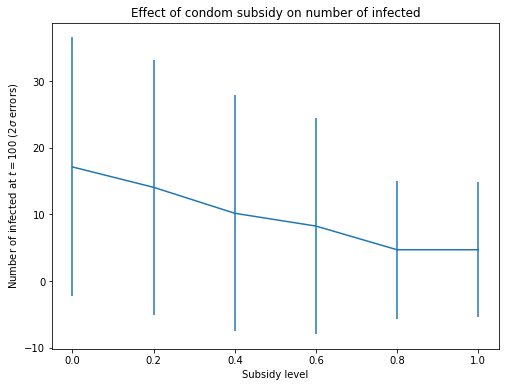

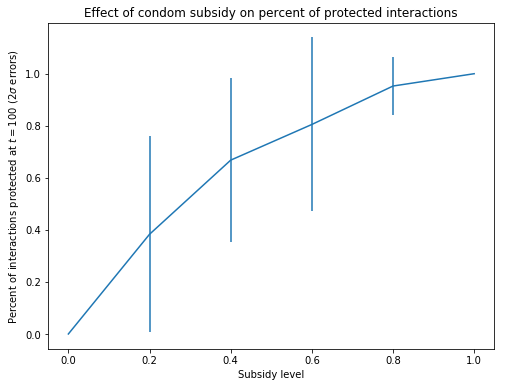

In [7]:
# Create figure
f = plt.figure(figsize=(8,6))
_ = plt.errorbar(sweep_means.index, sweep_means, 2 * sweep_std)
_ = plt.title("Effect of condom subsidy on number of infected")
_ = plt.xlabel("Subsidy level")
_ = plt.ylabel("Number of infected at $t=100$ ($2 \sigma$ errors)")

# Create figure
f = plt.figure(figsize=(8,6))
_ = plt.errorbar(sweep_pct_means.index, sweep_pct_means, 2 * sweep_pct_std)
_ = plt.title("Effect of condom subsidy on percent of protected interactions")
_ = plt.xlabel("Subsidy level")
_ = plt.ylabel("Percent of interactions protected at $t=100$ ($2 \sigma$ errors)")

In [8]:
# Get 2D grid means
sweep_means = pandas.DataFrame(subsidy_sweep_df.groupby(["subsidy", "prob_hookup"])["num_infected"].mean())
sweep_std = subsidy_sweep_df.groupby(["subsidy", "prob_hookup"])["num_infected"].std()
sweep_surface = sweep_means.reset_index().pivot(index="subsidy", columns="prob_hookup", values="num_infected")
sweep_surface

prob_hookup,0.1,0.3,0.5,0.7,0.9
subsidy,,,,,
0.0,1.40,11.85,22.65,24.75,25.00
0.2,1.80,6.65,16.60,22.10,23.20
0.4,1.10,4.75,7.65,16.55,20.80
0.6,1.05,2.85,7.40,12.20,17.75
0.8,1.00,2.00,3.45,6.35,10.65
1.0,1.05,1.40,3.10,6.55,11.35


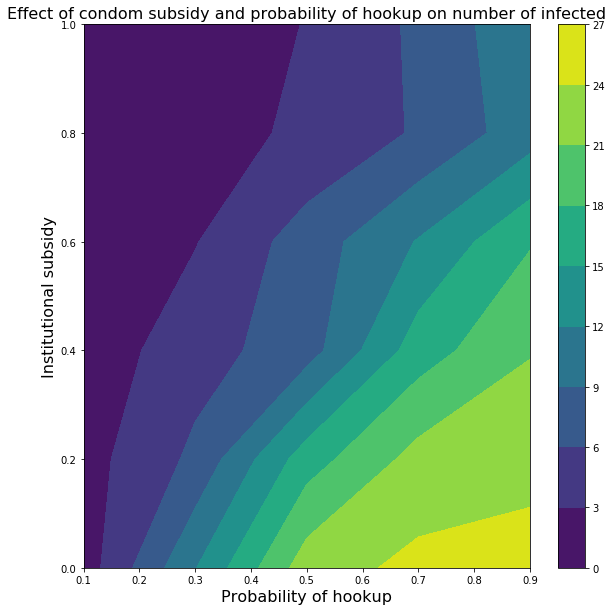

In [9]:
# Plot surface
f = plt.figure(figsize=(10, 10))
_ = plt.contourf(sweep_surface.columns, sweep_surface.index, sweep_surface)
_ = plt.colorbar()
_ = plt.title("Effect of condom subsidy and probability of hookup on number of infected",
              fontsize=16)
_ = plt.xlabel("Probability of hookup", fontsize=16)
_ = plt.ylabel("Institutional subsidy", fontsize=16)

Copyright (c) 2014, Michael Bommarito All rights reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

- Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

- Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE